In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [5]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            torch.cuda.empty_cache()

            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GENConv(channel_ls[i], channel_ls[i+1], learn_t=True, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [39]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=1, gamma=1, dropout=0.5):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        # new_A = F.tanh(F.relu(new_A))
        new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [7]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [8]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [9]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [10]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls, alpha, epoch_weight):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.L1Loss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)


    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss * epoch_weight
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.L1Loss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss

def reconstruction_loss_fn(gt_adj, pred_adj):
    l1_loss_fn = nn.L1Loss()
    return l1_loss_fn(gt_adj, pred_adj)

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [15]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=32)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=12)
channels_ls = [32, 64]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


7034338

In [16]:
def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
        reconstruction_losses = []
            
        if (epoch + 1) % 10 == 0:
            epoch_weight = 1 / (2 ** (0.05 * (epoch + completed_epochs + 1)))


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            # down_batch_loss = []
            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            # down_batch_loss.append(down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1]))
            down_loss = down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1])
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss

            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            # del down_batch_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            # up_batch_loss.append(up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], alpha=0.8, epoch_weight=epoch_weight))
            up_loss = up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], alpha=0.8, epoch_weight=epoch_weight)

            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            # up_loss = torch.mean(torch.stack(up_batch_loss))
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            # del up_batch_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)

            reconstruction_optimizer.zero_grad()

            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_ls[-1])[-1]
            torch.cuda.empty_cache()

            reconstruction_loss = reconstruction_loss_fn(up_adj_end, adj_hr.to(DEVICE))
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
        
            reconstruction_losses.append(reconstruction_loss.detach().item())
            del reconstruction_loss
            torch.cuda.empty_cache()


            # update hyperparameter that penalises the losses to be too far apart
            # total_loss_diff = np.abs(up_losses[-1] - down_losses[-1])
            # beta = (1 + total_loss_diff)
    
            # up_gamma = 1 + max(0, down_final_mae_ls[-1] - up_final_mae_ls[-1])
            # down_gamma = 1 + max(0, up_final_mae_ls[-1] - down_final_mae_ls[-1])


        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_reconstruction_loss = np.mean(reconstruction_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'ep {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, reconst. loss = {epoch_reconstruction_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [30]:
up_changer, down_changer, loss_log = train(100, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, 400, loss_log)

100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


ep 0: down loss = 0.061645143975814186, up loss = 0.10491473351915677, reconst. loss = 0.11815859377384186, down adj mae = 0.12186207125584285, up adj mae = 0.11906979108850162


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


ep 1: down loss = 0.05386046196023623, up loss = 0.10352100680271785, reconst. loss = 0.11804044495026271, down adj mae = 0.12659712259968123, up adj mae = 0.12094605093201001


100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


ep 2: down loss = 0.05538692635794481, up loss = 0.10433797538280487, reconst. loss = 0.11857673277457555, down adj mae = 0.12297721579670906, up adj mae = 0.1176895077029864


100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


ep 3: down loss = 0.04903429374098778, up loss = 0.10339658831556638, reconst. loss = 0.11885395646095276, down adj mae = 0.11940257251262665, up adj mae = 0.11767613639434178


100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


ep 4: down loss = 0.04693882601956526, up loss = 0.10280820727348328, reconst. loss = 0.1185122864941756, down adj mae = 0.12855951860547066, up adj mae = 0.11835593233505885


100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


ep 5: down loss = 0.046706087266405426, up loss = 0.10227970406413078, reconst. loss = 0.11768980696797371, down adj mae = 0.12217585742473602, up adj mae = 0.11860037843386333


100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


ep 6: down loss = 0.04419464431703091, up loss = 0.10133736208081245, reconst. loss = 0.11717948814233144, down adj mae = 0.1272213558355967, up adj mae = 0.11579929540554683


100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


ep 7: down loss = 0.041616332406798996, up loss = 0.1006208136677742, reconst. loss = 0.11750692998369534, down adj mae = 0.12459693600734074, up adj mae = 0.11575759078065555


100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


ep 8: down loss = 0.039479740584890045, up loss = 0.1017966444293658, reconst. loss = 0.11861969654758771, down adj mae = 0.12564846749107042, up adj mae = 0.12107841422160466


100%|██████████| 6/6 [00:11<00:00,  1.83s/it]


ep 9: down loss = 0.03953960910439491, up loss = 0.09570062533020973, reconst. loss = 0.11724797015388806, down adj mae = 0.12359993656476338, up adj mae = 0.11787136768301328


100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


ep 10: down loss = 0.04024165372053782, up loss = 0.09479938944180806, reconst. loss = 0.116567545880874, down adj mae = 0.1269667831559976, up adj mae = 0.11761708930134773


100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


ep 11: down loss = 0.03927184517184893, up loss = 0.09477403635780017, reconst. loss = 0.11637870594859123, down adj mae = 0.12484760334094365, up adj mae = 0.11657562976082166


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


ep 12: down loss = 0.039559739331404366, up loss = 0.09561133508880933, reconst. loss = 0.11668653289477031, down adj mae = 0.12418830146392186, up adj mae = 0.1187731958925724


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


ep 13: down loss = 0.039629717667897545, up loss = 0.0948359730343024, reconst. loss = 0.11626564090450604, down adj mae = 0.12439571817715962, up adj mae = 0.1181770662466685


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


ep 14: down loss = 0.04048497602343559, up loss = 0.09425331403811772, reconst. loss = 0.11583431934316953, down adj mae = 0.11740401883920033, up adj mae = 0.11631330971916516


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


ep 15: down loss = 0.04054254728058974, up loss = 0.09485962241888046, reconst. loss = 0.11639764035741489, down adj mae = 0.12657752012213072, up adj mae = 0.11932200441757838


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


ep 16: down loss = 0.04399454717834791, up loss = 0.09414074197411537, reconst. loss = 0.11581161245703697, down adj mae = 0.12412028263012569, up adj mae = 0.11760836963852246


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


ep 17: down loss = 0.04085602921744188, up loss = 0.0957355685532093, reconst. loss = 0.11726788183053334, down adj mae = 0.12428649514913559, up adj mae = 0.11823567499717076


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


ep 18: down loss = 0.04245666228234768, up loss = 0.09496953090031941, reconst. loss = 0.11632906397183736, down adj mae = 0.12222237015763919, up adj mae = 0.11738730470339458


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


ep 19: down loss = 0.04033487911025683, up loss = 0.09381700679659843, reconst. loss = 0.11510678504904111, down adj mae = 0.12167069688439369, up adj mae = 0.11425923680265744


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


ep 20: down loss = 0.04224354773759842, up loss = 0.09402056535085042, reconst. loss = 0.11521213253339131, down adj mae = 0.12059416125218074, up adj mae = 0.11464674895008405


100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


ep 21: down loss = 0.04099940632780393, up loss = 0.0935003434618314, reconst. loss = 0.11466200649738312, down adj mae = 0.12180094917615254, up adj mae = 0.11619359999895096


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


ep 22: down loss = 0.04119887389242649, up loss = 0.0929992397626241, reconst. loss = 0.11402874812483788, down adj mae = 0.11808947970469792, up adj mae = 0.11446791018048923


100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


ep 23: down loss = 0.04186194824675719, up loss = 0.09595729410648346, reconst. loss = 0.11654119690259297, down adj mae = 0.12853136037786803, up adj mae = 0.12079998850822449


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


ep 24: down loss = 0.04533810416857401, up loss = 0.09373543908198674, reconst. loss = 0.1152785172065099, down adj mae = 0.12318215767542522, up adj mae = 0.1165215087433656


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


ep 25: down loss = 0.04206660638252894, up loss = 0.09425419693191846, reconst. loss = 0.11572654296954472, down adj mae = 0.12703188632925352, up adj mae = 0.11569063862164815


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


ep 26: down loss = 0.0425886120647192, up loss = 0.09401179601748784, reconst. loss = 0.11496468633413315, down adj mae = 0.1297837719321251, up adj mae = 0.11796448503931363


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


ep 27: down loss = 0.04417276196181774, up loss = 0.09299097334345181, reconst. loss = 0.11412819599111874, down adj mae = 0.12641475846370062, up adj mae = 0.11602450907230377


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


ep 28: down loss = 0.04360084918638071, up loss = 0.09500167146325111, reconst. loss = 0.11628578354914983, down adj mae = 0.12653407206137976, up adj mae = 0.1163874256114165


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


ep 29: down loss = 0.04243362322449684, up loss = 0.09300335124135017, reconst. loss = 0.11401904498537381, down adj mae = 0.12212179104487102, up adj mae = 0.11549003298083942


100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


ep 30: down loss = 0.0444367000212272, up loss = 0.09421330317854881, reconst. loss = 0.1156347965200742, down adj mae = 0.12566674003998438, up adj mae = 0.11790178095300992


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


ep 31: down loss = 0.04332153002421061, up loss = 0.09264730910460155, reconst. loss = 0.11382093528906505, down adj mae = 0.12772783637046814, up adj mae = 0.11547135189175606


100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


ep 32: down loss = 0.04424111917614937, up loss = 0.09381473064422607, reconst. loss = 0.11486479764183362, down adj mae = 0.12062172715862592, up adj mae = 0.11772726227839787


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


ep 33: down loss = 0.04393870756030083, up loss = 0.09354554613431294, reconst. loss = 0.11451218277215958, down adj mae = 0.12279676770170529, up adj mae = 0.11635432516535123


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


ep 34: down loss = 0.04373368310431639, up loss = 0.09268084665139516, reconst. loss = 0.11358888695637386, down adj mae = 0.12692258631189665, up adj mae = 0.11629653101166089


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


ep 35: down loss = 0.04375206182400385, up loss = 0.09338049218058586, reconst. loss = 0.11403438573082288, down adj mae = 0.12763988971710205, up adj mae = 0.1167503334581852


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


ep 36: down loss = 0.04393645003437996, up loss = 0.09375220909714699, reconst. loss = 0.11465364570418994, down adj mae = 0.13074231271942457, up adj mae = 0.11772881944974263


100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


ep 37: down loss = 0.048647732784350715, up loss = 0.09355467061201732, reconst. loss = 0.11421794444322586, down adj mae = 0.12651457265019417, up adj mae = 0.11681862051288287


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


ep 38: down loss = 0.04417074409623941, up loss = 0.09609027951955795, reconst. loss = 0.11753709117571513, down adj mae = 0.12659557784597078, up adj mae = 0.11873302857081096


100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


ep 39: down loss = 0.04751706185440222, up loss = 0.09337122862537701, reconst. loss = 0.11416760335365932, down adj mae = 0.12617070600390434, up adj mae = 0.11584353695313136


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


ep 40: down loss = 0.04475380418201288, up loss = 0.09233396624525388, reconst. loss = 0.11285469805200894, down adj mae = 0.1278397316733996, up adj mae = 0.11820494880278905


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


ep 41: down loss = 0.04401457247634729, up loss = 0.09221568579475085, reconst. loss = 0.1127952088912328, down adj mae = 0.12425509716073672, up adj mae = 0.11366309473911922


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


ep 42: down loss = 0.044315783927838005, up loss = 0.09203441441059113, reconst. loss = 0.11277279754479726, down adj mae = 0.12057879567146301, up adj mae = 0.1141249140103658


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


ep 43: down loss = 0.04437093002100786, up loss = 0.09192496041456859, reconst. loss = 0.11252405494451523, down adj mae = 0.12727612753709158, up adj mae = 0.11409920205672582


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


ep 44: down loss = 0.04584735383590063, up loss = 0.09278642510374387, reconst. loss = 0.1135335626701514, down adj mae = 0.12333513175447781, up adj mae = 0.11547693610191345


100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


ep 45: down loss = 0.0441896878182888, up loss = 0.09197842081387837, reconst. loss = 0.11232991764942805, down adj mae = 0.12381982803344727, up adj mae = 0.11509694779912631


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


ep 46: down loss = 0.04418868074814478, up loss = 0.09193085009853046, reconst. loss = 0.11243602881828944, down adj mae = 0.1236250288784504, up adj mae = 0.11508197337388992


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


ep 47: down loss = 0.04494492088754972, up loss = 0.09267795458436012, reconst. loss = 0.11355957140525182, down adj mae = 0.12656707937518755, up adj mae = 0.11430637041727702


100%|██████████| 6/6 [00:09<00:00,  1.67s/it]


ep 48: down loss = 0.04295573818186919, up loss = 0.090970645348231, reconst. loss = 0.11110557367404301, down adj mae = 0.11996817961335182, up adj mae = 0.11244470998644829


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


ep 49: down loss = 0.045493895187973976, up loss = 0.09337673584620158, reconst. loss = 0.11372539152701695, down adj mae = 0.12768041342496872, up adj mae = 0.11570523555080096


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


ep 50: down loss = 0.04365170684953531, up loss = 0.09221374988555908, reconst. loss = 0.11265045404434204, down adj mae = 0.12750206018487611, up adj mae = 0.1146366943915685


100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


ep 51: down loss = 0.044291134302814804, up loss = 0.09107822924852371, reconst. loss = 0.11128432924548785, down adj mae = 0.12532345205545425, up adj mae = 0.11367998893062274


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


ep 52: down loss = 0.04472761042416096, up loss = 0.09568365911642711, reconst. loss = 0.11621549725532532, down adj mae = 0.13292320693532625, up adj mae = 0.12404017026225726


100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


ep 53: down loss = 0.045156882454951607, up loss = 0.08956065773963928, reconst. loss = 0.10959994917114575, down adj mae = 0.1182936504483223, up adj mae = 0.11199589694539706


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


ep 54: down loss = 0.04501117579638958, up loss = 0.09066920603315036, reconst. loss = 0.11080692956844966, down adj mae = 0.12457311774293582, up adj mae = 0.11283476650714874


100%|██████████| 6/6 [00:09<00:00,  1.67s/it]


ep 55: down loss = 0.04431408147017161, up loss = 0.09194439152876537, reconst. loss = 0.11296837031841278, down adj mae = 0.12740550935268402, up adj mae = 0.11530064791440964


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


ep 56: down loss = 0.04634784969190756, up loss = 0.0925862267613411, reconst. loss = 0.11268613487482071, down adj mae = 0.12110638370116551, up adj mae = 0.11657151579856873


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


ep 57: down loss = 0.044890984892845154, up loss = 0.09236970419685046, reconst. loss = 0.11291849240660667, down adj mae = 0.1251097433269024, up adj mae = 0.11490489294131596


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


ep 58: down loss = 0.04437654030819734, up loss = 0.09011076142390569, reconst. loss = 0.11059669901927312, down adj mae = 0.11929281676808993, up adj mae = 0.1122349885602792


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


ep 59: down loss = 0.04495535045862198, up loss = 0.09230594212810199, reconst. loss = 0.11260862648487091, down adj mae = 0.1251011515657107, up adj mae = 0.11333565289775531


100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


ep 60: down loss = 0.04401549510657787, up loss = 0.09085653846462567, reconst. loss = 0.11053462450702985, down adj mae = 0.12307413667440414, up adj mae = 0.11337571715315183


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 61: down loss = 0.0439823983858029, up loss = 0.09097500642140706, reconst. loss = 0.11108638718724251, down adj mae = 0.12619241575400034, up adj mae = 0.11268811176220576


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


ep 62: down loss = 0.0441238476584355, up loss = 0.09056621169050534, reconst. loss = 0.11025354887048404, down adj mae = 0.1210124467809995, up adj mae = 0.11173052216569583


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


ep 63: down loss = 0.04831498861312866, up loss = 0.09033622095982234, reconst. loss = 0.11108499765396118, down adj mae = 0.12924961869915327, up adj mae = 0.11128028854727745


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


ep 64: down loss = 0.047367433086037636, up loss = 0.09117564807335536, reconst. loss = 0.11121931423743565, down adj mae = 0.12668542439738908, up adj mae = 0.11376437296470006


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


ep 65: down loss = 0.04503805314501127, up loss = 0.09087155759334564, reconst. loss = 0.11081538473566373, down adj mae = 0.1273366411526998, up adj mae = 0.11674292137225468


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


ep 66: down loss = 0.04538103938102722, up loss = 0.09066804498434067, reconst. loss = 0.11132312069336574, down adj mae = 0.127441277106603, up adj mae = 0.11184653888146083


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


ep 67: down loss = 0.04538525082170963, up loss = 0.09185673917333285, reconst. loss = 0.11172494168082873, down adj mae = 0.12459629774093628, up adj mae = 0.11360337088505428


100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


ep 68: down loss = 0.046149088690678276, up loss = 0.09192651386062305, reconst. loss = 0.1123771034181118, down adj mae = 0.12905376652876535, up adj mae = 0.11575433860222499


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 69: down loss = 0.0468364010254542, up loss = 0.09176237632830937, reconst. loss = 0.1114762785534064, down adj mae = 0.12465037529667218, up adj mae = 0.11605939641594887


100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


ep 70: down loss = 0.049088592951496444, up loss = 0.09156534696618716, reconst. loss = 0.11097759132583936, down adj mae = 0.1251092217862606, up adj mae = 0.11422534907857577


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


ep 71: down loss = 0.045358097180724144, up loss = 0.0896679125726223, reconst. loss = 0.10973092665274937, down adj mae = 0.12415459752082825, up adj mae = 0.11306509375572205


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 72: down loss = 0.045973203455408417, up loss = 0.08899519344170888, reconst. loss = 0.10883594925204913, down adj mae = 0.1217876064280669, up adj mae = 0.10959137976169586


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 73: down loss = 0.04434740667541822, up loss = 0.08944616839289665, reconst. loss = 0.10889471819003423, down adj mae = 0.12352918336788814, up adj mae = 0.11219330380360286


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 74: down loss = 0.04749919349948565, up loss = 0.09033450732628505, reconst. loss = 0.10993522281448047, down adj mae = 0.12271958713730176, up adj mae = 0.11152360091606776


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


ep 75: down loss = 0.045594598477085434, up loss = 0.08875101680556934, reconst. loss = 0.10837611928582191, down adj mae = 0.12598819533983865, up adj mae = 0.11036941160758336


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


ep 76: down loss = 0.044567873080571495, up loss = 0.08859781175851822, reconst. loss = 0.10805180296301842, down adj mae = 0.11829111104210217, up adj mae = 0.10928242405255635


100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


ep 77: down loss = 0.04581888827184836, up loss = 0.08953212449947993, reconst. loss = 0.10851531599958737, down adj mae = 0.12682117894291878, up adj mae = 0.11111187810699145


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


ep 78: down loss = 0.04530201045175394, up loss = 0.09184871117273967, reconst. loss = 0.11148664355278015, down adj mae = 0.1230538176993529, up adj mae = 0.11331605662902196


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


ep 79: down loss = 0.044886451214551926, up loss = 0.08985034997264545, reconst. loss = 0.10917649418115616, down adj mae = 0.12571204205354056, up adj mae = 0.11067997291684151


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 80: down loss = 0.04549033505221208, up loss = 0.09054000675678253, reconst. loss = 0.11019491404294968, down adj mae = 0.12424238522847493, up adj mae = 0.11127976700663567


100%|██████████| 6/6 [00:09<00:00,  1.67s/it]


ep 81: down loss = 0.04661990391711394, up loss = 0.08942300205429395, reconst. loss = 0.1091638095676899, down adj mae = 0.1272736315925916, up adj mae = 0.10981978476047516


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


ep 82: down loss = 0.04651725043853124, up loss = 0.08774478733539581, reconst. loss = 0.106950710217158, down adj mae = 0.12665519366661707, up adj mae = 0.10827081898848216


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


ep 83: down loss = 0.04573896216849486, up loss = 0.08794361477096875, reconst. loss = 0.10742665827274323, down adj mae = 0.12204879149794579, up adj mae = 0.11014925688505173


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 84: down loss = 0.04684439984460672, up loss = 0.08991139382123947, reconst. loss = 0.10877084359526634, down adj mae = 0.11943308015664418, up adj mae = 0.1125819447139899


100%|██████████| 6/6 [00:09<00:00,  1.67s/it]


ep 85: down loss = 0.045122802878419556, up loss = 0.08892486865321796, reconst. loss = 0.1078056072195371, down adj mae = 0.1297300929824511, up adj mae = 0.11078101148207982


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 86: down loss = 0.04556208041807016, up loss = 0.0892490732173125, reconst. loss = 0.10840222239494324, down adj mae = 0.12669474010666212, up adj mae = 0.11407604689399402


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


ep 87: down loss = 0.047651405135790505, up loss = 0.08947393298149109, reconst. loss = 0.10882038250565529, down adj mae = 0.12632400542497635, up adj mae = 0.11130494996905327


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


ep 88: down loss = 0.045593010261654854, up loss = 0.08955767750740051, reconst. loss = 0.10925102482239406, down adj mae = 0.12575592597325644, up adj mae = 0.11066299304366112


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


ep 89: down loss = 0.04629951405028502, up loss = 0.08834034949541092, reconst. loss = 0.107893871764342, down adj mae = 0.12485445166627566, up adj mae = 0.10799431925018628


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 90: down loss = 0.046739388878146805, up loss = 0.08716411888599396, reconst. loss = 0.10630001624425252, down adj mae = 0.126639852921168, up adj mae = 0.10806265970071156


100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


ep 91: down loss = 0.047728272154927254, up loss = 0.08897279699643452, reconst. loss = 0.10810603325565656, down adj mae = 0.12622970218459764, up adj mae = 0.11055033778150876


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


ep 92: down loss = 0.04746040950218836, up loss = 0.08872379610935847, reconst. loss = 0.10737672075629234, down adj mae = 0.12256643300255139, up adj mae = 0.1112228309114774


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


ep 93: down loss = 0.04657863825559616, up loss = 0.08851271495223045, reconst. loss = 0.10836321736375491, down adj mae = 0.1266366516550382, up adj mae = 0.10955575356880824


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


ep 94: down loss = 0.04501259575287501, up loss = 0.08891978363196056, reconst. loss = 0.10791726658741634, down adj mae = 0.1283424993356069, up adj mae = 0.11082585031787555


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


ep 95: down loss = 0.04770603651801745, up loss = 0.08704269304871559, reconst. loss = 0.10614529252052307, down adj mae = 0.12377282604575157, up adj mae = 0.10806451613704364


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


ep 96: down loss = 0.04516006571551164, up loss = 0.0877223014831543, reconst. loss = 0.10668896759549777, down adj mae = 0.12084328879912694, up adj mae = 0.10931149621804555


100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


ep 97: down loss = 0.04666477255523205, up loss = 0.09280029435952504, reconst. loss = 0.11280671879649162, down adj mae = 0.1302959385017554, up adj mae = 0.11429301897684734


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


ep 98: down loss = 0.045854240035017334, up loss = 0.08848776916662852, reconst. loss = 0.10730658347407977, down adj mae = 0.11912308757503827, up adj mae = 0.10917851701378822


100%|██████████| 6/6 [00:09<00:00,  1.64s/it]

ep 99: down loss = 0.045343514531850815, up loss = 0.08756070584058762, reconst. loss = 0.10643802707393964, down adj mae = 0.12429756795366605, up adj mae = 0.10657237966855367


In [31]:
min(loss_log['up_end_mae'])

0.10657237966855367

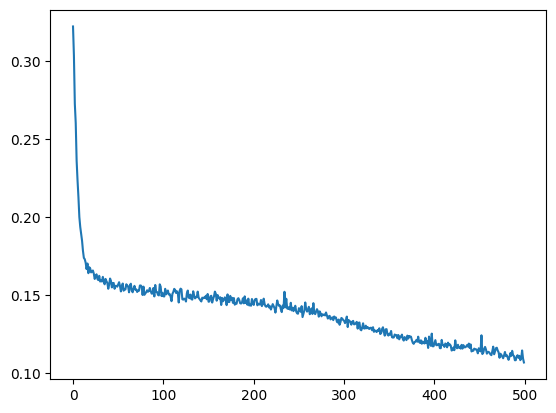

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [33]:
torch.save(up_changer.state_dict(), 'submission_files/tim_deep4/up_change500.pth')

In [34]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


In [35]:
torch.save(test_predictions, 'submission_files/tim_deep4/tim_deep4_pred500.pt')

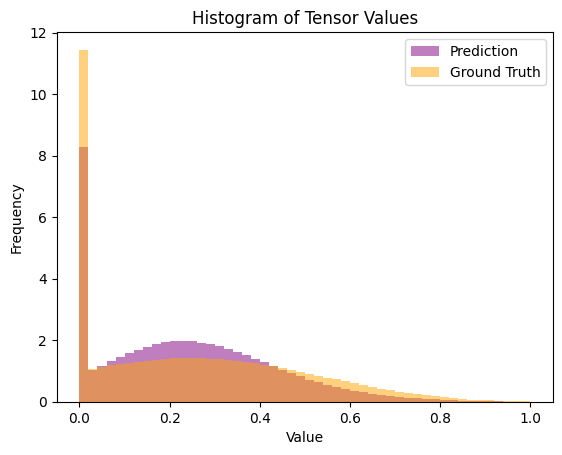

In [36]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

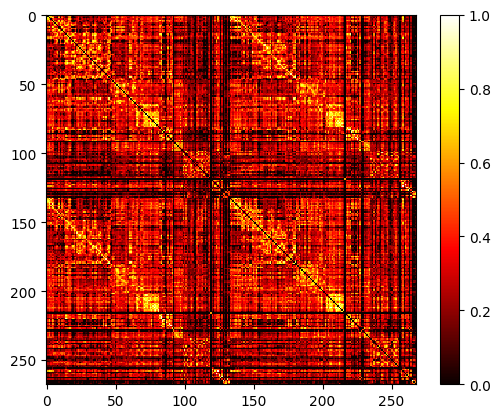

In [29]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [37]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep4/tim_deep4_pred500.csv')

# Cross Validation

In [11]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [12]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [15]:
cross_validate(5, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


epoch 0: down loss = 0.16564956307411194, up loss = 0.17200086265802383
Down end adj mae 0.28989551216363907
Up end adj mae 0.30541523545980453


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 1: down loss = 0.1615280844271183, up loss = 0.16848218068480492
Down end adj mae 0.2799903079867363
Up end adj mae 0.29920385777950287


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


epoch 2: down loss = 0.1559770405292511, up loss = 0.16499020531773567
Down end adj mae 0.27102500945329666
Up end adj mae 0.29710303246974945


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 3: down loss = 0.15054432675242424, up loss = 0.16159073635935783
Down end adj mae 0.2658237814903259
Up end adj mae 0.28980008512735367


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 4: down loss = 0.14580555632710457, up loss = 0.15819920599460602
Down end adj mae 0.24981610849499702
Up end adj mae 0.2819031700491905
begin validation


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
